In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
files_dir = "/kaggle/input/network-intrusion-dataset"

In [3]:
files = os.listdir("/kaggle/input/network-intrusion-dataset")

In [4]:
files

['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']

In [5]:
data_frames = []

In [6]:
for file in files:
    file_path = os.path.join(files_dir,file)
    data = pd.read_csv(file_path)
    data_frames.append(data)

In [7]:
data = pd.concat(data_frames, ignore_index = True)

In [8]:
data.columns = data.columns.str.strip()

# EDA & Preprocessing

In [9]:
data['Label'].value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [10]:
replace_dict = {'Web Attack � Brute Force':'Brute Force',
               'Web Attack � XSS':'XSS', 
                'Web Attack � Sql Injection':'SQL Injection'}

In [11]:
data['Label'] = data['Label'].map(replace_dict).fillna(data['Label'])

In [12]:
data.duplicated().sum()

308381

In [13]:
data.drop_duplicates(keep='first', inplace = True)

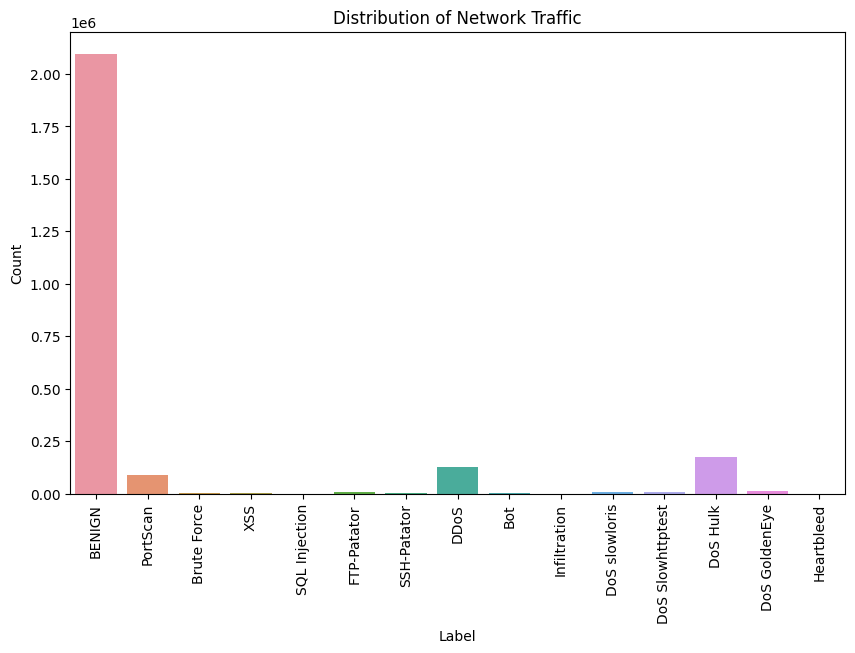

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=data)
plt.title('Distribution of Network Traffic')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [19]:
X = data.drop(columns=['Label'])
y = data['Label']

In [21]:
X.replace([np.inf,-np.inf],np.nan, inplace=True)

In [22]:
X.isna().sum().sort_values(ascending=False)

Flow Packets/s          1564
Flow Bytes/s            1564
Fwd Avg Packets/Bulk       0
Fwd Avg Bytes/Bulk         0
Fwd Header Length.1        0
                        ... 
Fwd IAT Min                0
Fwd IAT Max                0
Fwd IAT Std                0
Fwd IAT Mean               0
Fwd PSH Flags              0
Length: 78, dtype: int64

In [24]:
X['Flow Bytes/s'] = X['Flow Bytes/s'].fillna(X['Flow Bytes/s'].median())
X['Flow Packets/s'] = X['Flow Packets/s'].fillna(X['Flow Packets/s'].median())

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [30]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced')

In [31]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)

In [32]:
y_pred = rf.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

                  precision    recall  f1-score   support

          BENIGN       1.00      0.99      1.00    628945
             Bot       0.16      0.99      0.28       586
     Brute Force       0.80      0.58      0.67       441
            DDoS       1.00      1.00      1.00     38405
   DoS GoldenEye       0.99      1.00      0.99      3086
        DoS Hulk       0.99      1.00      1.00     51855
DoS Slowhttptest       0.99      0.99      0.99      1568
   DoS slowloris       1.00      0.99      0.99      1615
     FTP-Patator       1.00      1.00      1.00      1780
      Heartbleed       1.00      0.67      0.80         3
    Infiltration       1.00      0.73      0.84        11
        PortScan       0.99      1.00      0.99     27246
   SQL Injection       1.00      0.17      0.29         6
     SSH-Patator       1.00      1.00      1.00       966
             XSS       0.18      0.68      0.28       196

        accuracy                           0.99    756709
       macro

# Feature Selection

In [34]:
feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()

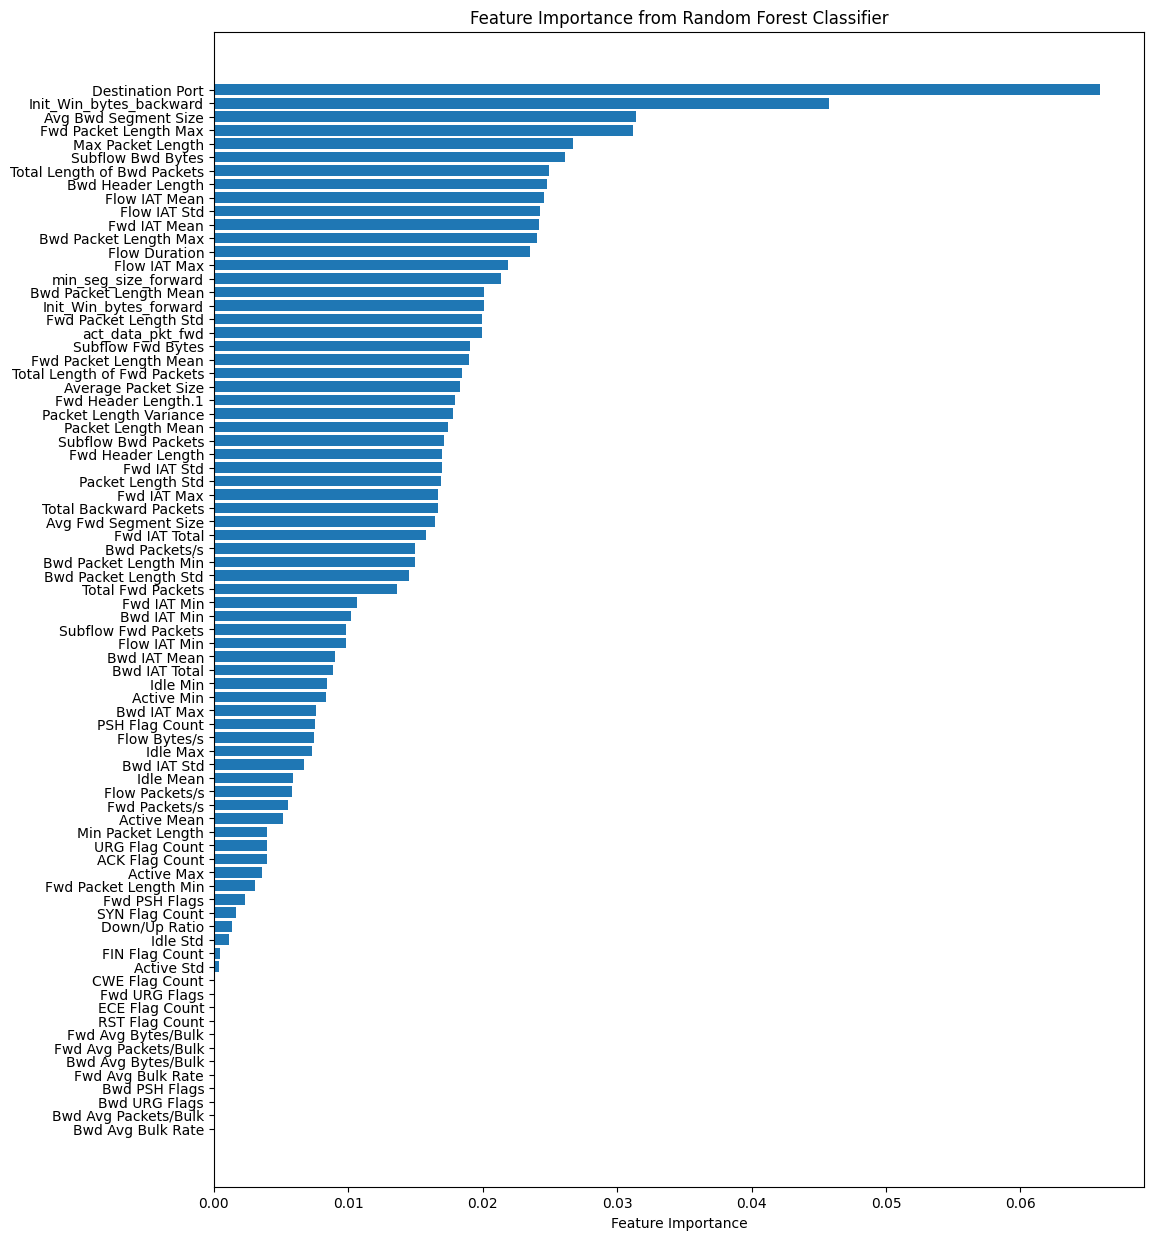

In [35]:
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), data.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

In [60]:
data.columns[sorted_idx]

Index(['Bwd Avg Bulk Rate', 'Bwd Avg Packets/Bulk', 'Bwd URG Flags',
       'Bwd PSH Flags', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bytes/Bulk', 'RST Flag Count',
       'ECE Flag Count', 'Fwd URG Flags', 'CWE Flag Count', 'Active Std',
       'FIN Flag Count', 'Idle Std', 'Down/Up Ratio', 'SYN Flag Count',
       'Fwd PSH Flags', 'Fwd Packet Length Min', 'Active Max',
       'ACK Flag Count', 'URG Flag Count', 'Min Packet Length', 'Active Mean',
       'Fwd Packets/s', 'Flow Packets/s', 'Idle Mean', 'Bwd IAT Std',
       'Idle Max', 'Flow Bytes/s', 'PSH Flag Count', 'Bwd IAT Max',
       'Active Min', 'Idle Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Flow IAT Min', 'Subflow Fwd Packets', 'Bwd IAT Min', 'Fwd IAT Min',
       'Total Fwd Packets', 'Bwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packets/s', 'Fwd IAT Total', 'Avg Fwd Segment Size',
       'Total Backward Packets', 'Fwd IAT Max', 'Packet Length Std',
       'Fwd I

In [61]:
top_k = 25

In [62]:
top_features = data.columns[sorted_idx[-top_k:]]
print(f"Top {top_k} Features: {top_features}")

Top 25 Features: Index(['Packet Length Variance', 'Fwd Header Length.1', 'Average Packet Size',
       'Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Subflow Fwd Bytes', 'act_data_pkt_fwd', 'Fwd Packet Length Std',
       'Init_Win_bytes_forward', 'Bwd Packet Length Mean',
       'min_seg_size_forward', 'Flow IAT Max', 'Flow Duration',
       'Bwd Packet Length Max', 'Fwd IAT Mean', 'Flow IAT Std',
       'Flow IAT Mean', 'Bwd Header Length', 'Total Length of Bwd Packets',
       'Subflow Bwd Bytes', 'Max Packet Length', 'Fwd Packet Length Max',
       'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Destination Port'],
      dtype='object')


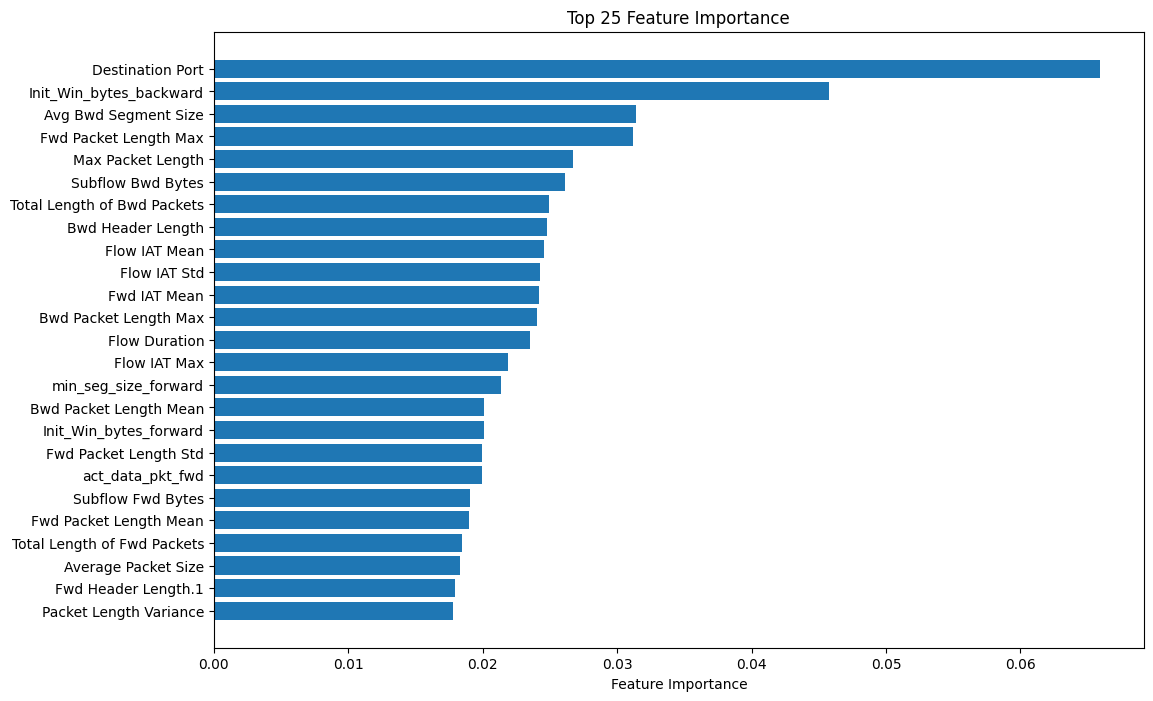

In [63]:
plt.figure(figsize=(12, 8))
plt.barh(range(top_k), feature_importance[sorted_idx[-top_k:]], align='center')
plt.yticks(range(top_k), top_features)
plt.xlabel('Feature Importance')
plt.title(f'Top {top_k} Feature Importance')
plt.show()

In [40]:
X_top_k = data[top_features]

In [41]:
corr_matrix = X_top_k.corr()

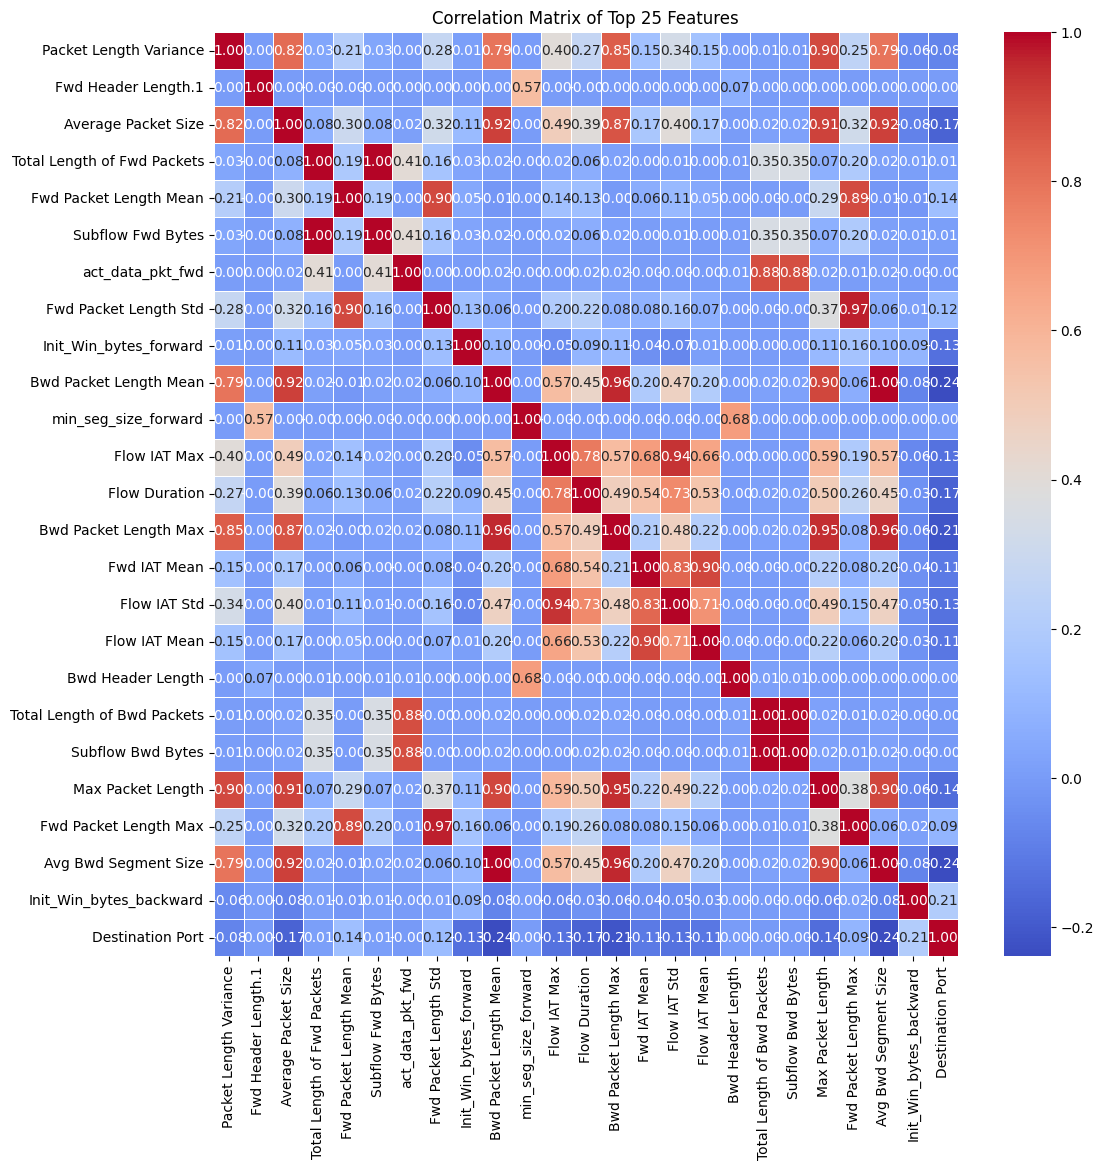

In [42]:
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title(f'Correlation Matrix of Top {top_k} Features')
plt.show()

From the above feature importances we get the top 25 important features for prediction, after that we get the correlation matrix to check for corelation between the top 25 features
Using the corelation and the feature importances we can remove certain features, which are

- Bwd Header Length – Correlated with other "Bwd" features and low importance.

- Flow IAT Std – Correlated with Flow IAT Max, Flow IAT Mean, and Flow IAT Std.

- Fwd IAT Std – Highly correlated with Fwd IAT Max, Fwd IAT Mean.

- Subflow Bwd Packets – Low importance and highly correlated with other Subflow features.

- Packet Length Mean – Low importance and redundant with other packet-related features.

- min_seg_size_forward – Low importance.

- Packet Length Std – Low importance and redundant.

- Total Backward Packets – Low importance.

- Average Packet Size – Low importance.

# Model Fitting and Comparison

In [64]:
X = data.drop(columns=['Label'])
y = data['Label']

In [65]:
X = data[top_features]

In [68]:
X = X.drop(columns=['Bwd Header Length',
    'min_seg_size_forward',
    'Total Length of Bwd Packets',
    'Average Packet Size',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Max Packet Length',  
    'Fwd IAT Mean',      
    'Flow IAT Mean',
    'Packet Length Variance',
    'Fwd Header Length.1'
])

In [69]:
X.columns

Index(['Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Subflow Fwd Bytes', 'act_data_pkt_fwd', 'Fwd Packet Length Std',
       'Init_Win_bytes_forward', 'Bwd Packet Length Mean', 'Flow IAT Max',
       'Flow Duration', 'Bwd Packet Length Max', 'Fwd Packet Length Max',
       'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Destination Port'],
      dtype='object')

In [70]:
X.replace([np.inf,-np.inf],np.nan, inplace=True)

In [71]:
X.columns

Index(['Total Length of Fwd Packets', 'Fwd Packet Length Mean',
       'Subflow Fwd Bytes', 'act_data_pkt_fwd', 'Fwd Packet Length Std',
       'Init_Win_bytes_forward', 'Bwd Packet Length Mean', 'Flow IAT Max',
       'Flow Duration', 'Bwd Packet Length Max', 'Fwd Packet Length Max',
       'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Destination Port'],
      dtype='object')

In [72]:
X.isna().sum()

Total Length of Fwd Packets    0
Fwd Packet Length Mean         0
Subflow Fwd Bytes              0
act_data_pkt_fwd               0
Fwd Packet Length Std          0
Init_Win_bytes_forward         0
Bwd Packet Length Mean         0
Flow IAT Max                   0
Flow Duration                  0
Bwd Packet Length Max          0
Fwd Packet Length Max          0
Avg Bwd Segment Size           0
Init_Win_bytes_backward        0
Destination Port               0
dtype: int64

In [73]:
X_scaled = scaler.fit_transform(X)

In [74]:
y_encoded = label_encoder.fit_transform(y)

Since the data is very large using only a subset of the data to check which model is good.

In [75]:
X_subset, _, y_subset, _ = train_test_split(
    X_scaled, y_encoded,
    test_size=0.85,
    random_state=42,
    stratify=y_encoded
)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset,
    test_size=0.3,
    random_state=42,
    stratify=y_subset
)

In [77]:
X_train.shape

(264847, 14)

In [92]:
param_grids = {
    'RF': {'n_estimators':[75,100], 'max_depth':[10,20], 'class_weight':['balanced']},
    'XGB': {'n_estimators':[100], 'learning_rate':[0.01], 'max_depth':[6]},
    'LR': {'C':[0.1,1], 'solver':['lbfgs'], 'max_iter':[1000]},
}

In [82]:
results=[]
def eval_model(name, model, grid=None, use_proba=True):
    start=time.time()
    if grid:
        search=RandomizedSearchCV(model, grid, n_iter=4, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42, verbose = 2)
        search.fit(X_train, y_train)
        model=search.best_estimator_
    else:
        model.fit(X_train, y_train)
    train_time=time.time()-start

    start=time.time()
    preds=model.predict(X_test)
    pred_time=time.time()-start

    acc=accuracy_score(y_test, preds)
    f1=classification_report(y_test, preds, output_dict=True, zero_division=0)['weighted avg']['f1-score']
    auc=roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr') if use_proba else np.nan

    results.append({'Model':name,'Accuracy':acc,'F1-Score':f1,'AUC-ROC':auc,
                    'Train Time':round(train_time,2),'Predict Time':round(pred_time,2)})

In [83]:
eval_model('Random Forest', RandomForestClassifier(random_state=42), param_grids['RF'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [84]:
xgb=XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, use_label_encoder=False, eval_metric='logloss')
eval_model('XGBoost', xgb, param_grids['XGB'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [85]:
eval_model('Logistic Regression', LogisticRegression(class_weight='balanced'), param_grids['LR'], use_proba=True)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [88]:
nn=tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)),activation='softmax')
])
nn.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
start=time.time()
nn.fit(X_train,y_train,epochs=10,batch_size=32,verbose=1)
train_time=time.time()-start
start=time.time()
y_pred_nn=np.argmax(nn.predict(X_test),axis=1)
pred_time=time.time()-start
results.append({'Model':'Neural Network','Accuracy':accuracy_score(y_test,y_pred_nn),
                'F1-Score':classification_report(y_test,y_pred_nn,output_dict=True,zero_division=0)['weighted avg']['f1-score'],
                'AUC-ROC':roc_auc_score(y_test,nn.predict(X_test),multi_class='ovr'),
                'Train Time':round(train_time,2),'Predict Time':round(pred_time,2)})

Epoch 1/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9358 - loss: 0.2535
Epoch 2/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9627 - loss: 0.1075
Epoch 3/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9661 - loss: 0.1054
Epoch 4/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9677 - loss: 0.0849
Epoch 5/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9693 - loss: 0.0777
Epoch 6/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9715 - loss: 0.0697
Epoch 7/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9743 - loss: 0.0661
Epoch 8/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9771 - loss: 0.0600
Epoch 9/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9798 - loss: 0.0549
Epoch 10/10
8277/8277 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9819 - loss: 0.0502
3548/3548 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3548/3548 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [93]:
results = pd.DataFrame(results)

In [96]:
results

,Model,Accuracy,F1-Score,AUC-ROC,Train Time,Predict Time
0,Random Forest,0.996159,0.996460,0.948287,121.11,1.00
1,XGBoost,0.992256,0.991531,0.912329,14.76,0.07
2,Logistic Regression,0.664796,0.766964,0.961539,222.00,0.01
3,Neural Network,0.987657,0.987191,0.943436,110.66,5.91


| Model              | F1‑Score | AUC‑ROC | Train Time (s) | Predict Time (s) | Verdict                                                                                 |
|--------------------|----------|---------|----------------|------------------|-----------------------------------------------------------------------------------------|
| **Random Forest**  | 0.9965   | 0.9483  | 121.11         | 1.00             | Best overall: highest F1, excellent accuracy, moderate training time, very fast inference. |
| **XGBoost**        | 0.9915   | 0.9123  | 14.76          | 0.07             | Almost as accurate, dramatically faster to train and predict. Great if compute/time is tight. |
| **Neural Network** | 0.9872   | 0.9434  | 110.66         | 5.91             | Good performance but slower inference — use only if you need deep‑learning features.      |
| **Logistic Regression** | 0.7669 | 0.9615 | 222.00       | 0.01             | Poor F1 (misses attacks) despite high AUC. Not recommended.                               |
| **SVM** | -   | -  | Takes a lot of time to train         | -             | Does not train easily as the dimensionality is high. |

# Using XGBoost for whole data

I used XGBoost because the F1-Score is quite comparable to RandomForest(which has best F1-Score), and its training spped is much more efficient as it uses GPU

In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.3,
    stratify=y_encoded,
    random_state=42
)

In [98]:
X_train, y_train = SMOTE(k_neighbors=1, random_state=42).fit_resample(X_train, y_train)

In [121]:
model = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    gpu_id=0,
    n_estimators=500,
    learning_rate=0.001,
    max_depth=10,
    use_label_encoder=False,
    eval_metric='logloss',
    verbose=2
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [124]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100}%")
print("AUC‑ROC:", roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))
print("\nClassification Report:\n", classification_report(y_test, y_pred,target_names=label_encoder.classes_, zero_division=0))

Accuracy: 98.09437974175013%
AUC‑ROC: 0.9872231225821015

Classification Report:
                   precision    recall  f1-score   support

          BENIGN       1.00      0.98      0.99    628945
             Bot       0.16      1.00      0.27       586
     Brute Force       0.16      0.50      0.24       441
            DDoS       0.98      1.00      0.99     38405
   DoS GoldenEye       0.96      1.00      0.98      3086
        DoS Hulk       0.90      1.00      0.94     51855
DoS Slowhttptest       0.85      0.99      0.91      1568
   DoS slowloris       0.86      0.99      0.92      1615
     FTP-Patator       0.98      1.00      0.99      1780
      Heartbleed       1.00      1.00      1.00         3
    Infiltration       0.60      0.82      0.69        11
        PortScan       0.98      1.00      0.99     27246
   SQL Injection       0.07      0.33      0.12         6
     SSH-Patator       0.98      1.00      0.99       966
             XSS       0.07      0.77      0.13

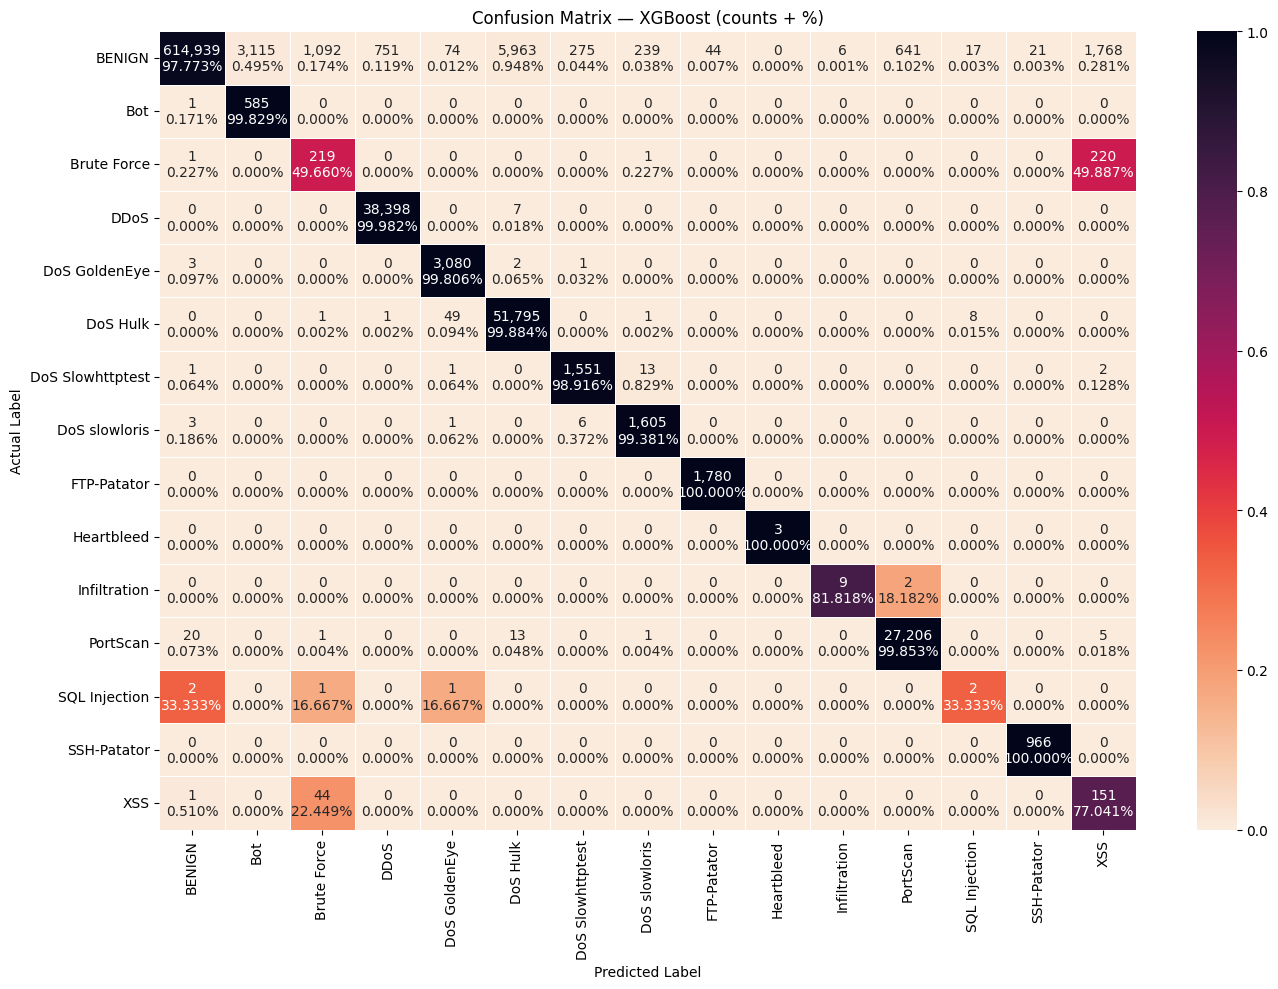

In [131]:
cm = confusion_matrix(y_test, model.predict(X_test))
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = [[f"{cm[i, j]:,}\n{cm_pct[i, j]:.3%}" for j in range(cm.shape[1])] 
          for i in range(cm.shape[0])]

plt.figure(figsize=(14, 10))
sns.heatmap(
    cm_pct,
    annot=labels,
    fmt='',
    cmap='rocket_r',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    linewidths=0.5
)
plt.title('Confusion Matrix — XGBoost (counts + %)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

| Class             | Precision | Recall | F1‑Score | Support |
|-------------------|-----------|--------|----------|---------|
| BENIGN            | 1.00      | 0.98   | 0.99     | 628,945 |
| Bot               | 0.16      | 1.00   | 0.27     | 586     |
| Brute Force       | 0.16      | 0.50   | 0.24     | 441     |
| DDoS              | 0.98      | 1.00   | 0.99     | 38,405  |
| DoS GoldenEye     | 0.96      | 1.00   | 0.98     | 3,086   |
| DoS Hulk          | 0.90      | 1.00   | 0.94     | 51,855  |
| DoS Slowhttptest  | 0.85      | 0.99   | 0.91     | 1,568   |
| DoS slowloris     | 0.86      | 0.99   | 0.92     | 1,615   |
| FTP‑Patator       | 0.98      | 1.00   | 0.99     | 1,780   |
| Heartbleed        | 1.00      | 1.00   | 1.00     | 3       |
| Infiltration      | 0.60      | 0.82   | 0.69     | 11      |
| PortScan          | 0.98      | 1.00   | 0.99     | 27,246  |
| SQL Injection     | 0.07      | 0.33   | 0.12     | 6       |
| SSH‑Patator       | 0.98      | 1.00   | 0.99     | 966     |
| XSS               | 0.07      | 0.77   | 0.13     | 196     |
| **Accuracy**      | —         | —      | 0.98     | 756,709 |
| **Macro avg**     | 0.70      | 0.89   | 0.74     | 756,709 |
| **Weighted avg**  | 0.99      | 0.98   | 0.98     | 756,709 |


In [130]:
import joblib

pipeline = {
    "scaler": scaler,
    "model": model,
    "label_encoder": label_encoder
}

joblib.dump(pipeline, "xgb_pipeline.joblib")

['xgb_pipeline.joblib']